























































# Proyecto
Cristian Leilael Rico Espinosa

Matrícula: A01707023

Proyecto para el Módulo 2 de "Desarrollo de aplicaciones avanzadas de ciencias computacionales". En este se realizará un modelo el cual se entrenará con imágenes de paisajes para que, posteriormente, pueda identificar imágenes pertenecientes a estos.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


base_dir = '.\\Model\\images\\'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

## Preprocesado de Datos

Se comienza con la carga y preprocesamiento de imágenes desde directorios, escalando sus valores de píxeles al rango de 0 a 1 para, posteriormente, crear generadores de datos los cuales serán utilizados durante el entrenamiento y la prueba del modelo.

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size= 32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size= 32,
    class_mode='categorical'
)

Found 8400 images belonging to 5 classes.
Found 2100 images belonging to 5 classes.


### Imágenes de *Train*

Para comprobar si la conversión se hizo adecuadamente, se utiliza *plot* para mostrar visualizaciones de algunas de las imágenes.

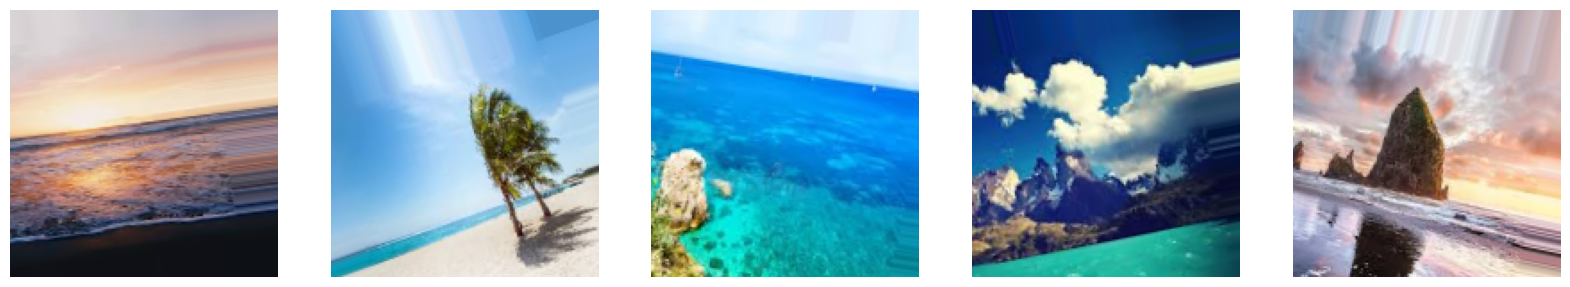

In [12]:
plt.figure(figsize=(20, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    batch = next(train_generator)
    image = batch[0][0]
    plt.imshow(image)
    plt.axis('off')
plt.show()

### Imágenes de *Test*

Para comprobar si la conversión se hizo adecuadamente, se utiliza *plot* para mostrar visualizaciones de algunas de las imágenes.

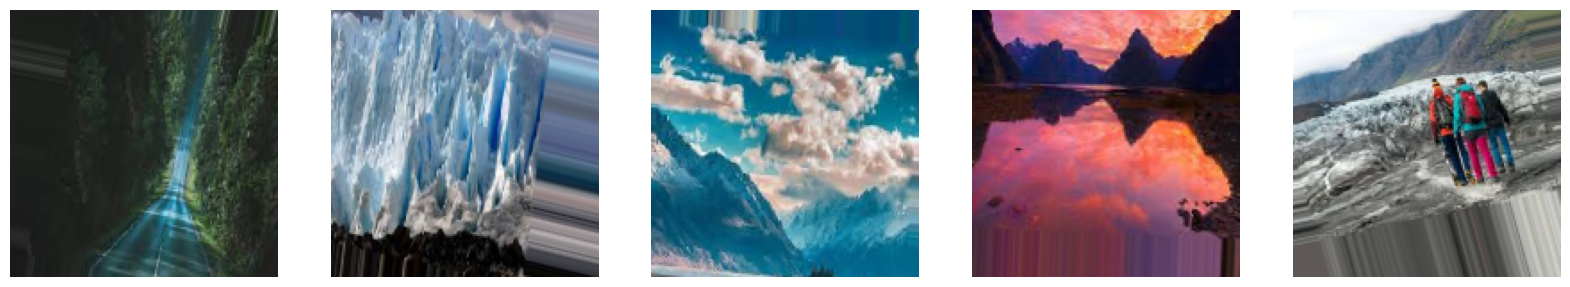

In [13]:
plt.figure(figsize=(20, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    batch = next(test_generator)
    image = batch[0][0]
    plt.imshow(image)
    plt.axis('off')
plt.show()

### Creación de Modelo

In [14]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False


# En caso de requerir fine tune, cambiar trainable a true
# fine_tune_at = 100


# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False


model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))  # 5 clases de salida

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch=200,
    epochs=80
)

acc = history.history['acc']
loss = history.history['loss']

model.save('2ndrun.keras')

Epoch 1/80
200/200 ━━━━━━━━━━━━━━━━━━━━ 77s 349ms/step - acc: 0.2973 - loss: 0.6619
Epoch 2/80
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - acc: 0.5082 - loss: 0.4397
Epoch 3/80


c:\Users\crisb\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


200/200 ━━━━━━━━━━━━━━━━━━━━ 65s 322ms/step - acc: 0.5595 - loss: 0.4085
Epoch 4/80
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - acc: 0.6251 - loss: 0.3737 
Epoch 5/80
200/200 ━━━━━━━━━━━━━━━━━━━━ 64s 316ms/step - acc: 0.6378 - loss: 0.3579
Epoch 6/80
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - acc: 0.6645 - loss: 0.3381 
Epoch 7/80
200/200 ━━━━━━━━━━━━━━━━━━━━ 66s 324ms/step - acc: 0.6629 - loss: 0.3361
Epoch 8/80
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - acc: 0.6707 - loss: 0.3353
Epoch 9/80
200/200 ━━━━━━━━━━━━━━━━━━━━ 71s 341ms/step - acc: 0.6765 - loss: 0.3252
Epoch 10/80
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - acc: 0.7030 - loss: 0.3035 
Epoch 11/80
200/200 ━━━━━━━━━━━━━━━━━━━━ 65s 320ms/step - acc: 0.6915 - loss: 0.3073
Epoch 12/80
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - acc: 0.6957 - loss: 0.3088 
Epoch 13/80
200/200 ━━━━━━━━━━━━━━━━━━━━ 65s 323ms/step - acc: 0.7078 - loss: 0.3011
Epoch 14/80
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - acc: 0.7162 - loss: 0.2934

<Figure size 640x480 with 0 Axes>

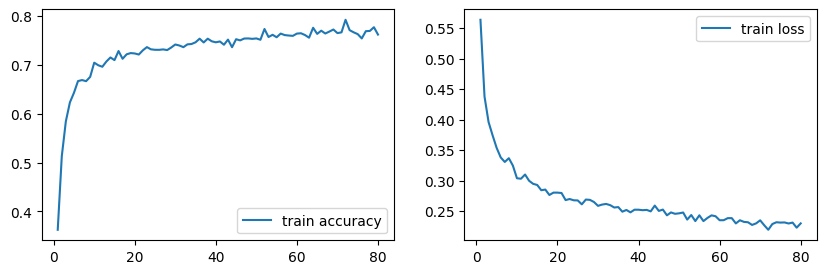

In [16]:
epochs = range(1, len(acc)+1)

plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2, figsize=(10, 3))
axarr[0].plot(epochs,acc,label='train accuracy')
axarr[0].legend()
axarr[1].plot(epochs,loss,label='train loss')
axarr[1].legend()

In [17]:
test_loss, test_acc = model.evaluate(test_generator)
print('\ntest acc :\n', test_acc)

predictions = model.predict(test_generator)
predict_class = (predictions > 0.5).astype("int32")
predict_class.shape


66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 360ms/step - acc: 0.7679 - loss: 0.2314

test acc :
 0.7685714364051819
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 325ms/step


(2100, 5)

### Comparación de Resultados

In [21]:
test_imgs = test_generator[0][0]
test_labels = test_generator[0][1]


predictions = model.predict(test_imgs)
classes_x = np.argmax(predictions,axis=1)
classes_x

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([1, 2, 2, 0, 1, 4, 4, 2, 2, 3, 0, 1, 0, 1, 4, 4, 3, 3, 1, 1, 2, 1,
       0, 4, 3, 0, 4, 1, 2, 0, 0, 1], dtype=int64)

### Matriz de Confusión (Seaborn)

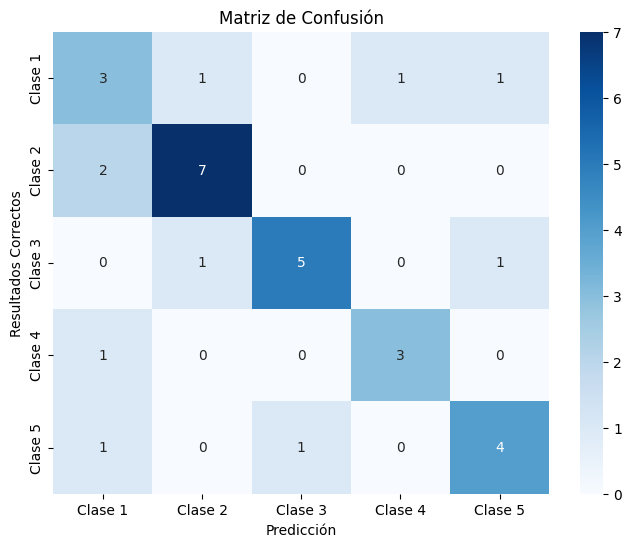

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obtener las etiquetas reales
true_labels = np.argmax(test_labels, axis=1)

# Obtener las predicciones del modelo
predicted_labels = np.argmax(predictions, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5"], yticklabels=["Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5"])
plt.xlabel('Predicción')
plt.ylabel('Resultados Correctos')
plt.title('Matriz de Confusión')
plt.show()